# House Price Prediction



## Imports and loading data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb

In [2]:
df = pd.read_csv('/home/otsalah/myGithub/datasets/housing.csv')

## Exploring the Data

In [3]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


- Numerical values need to be scaled
- Non-numerical values need to be encoded

In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

- As the number of the missing values is small, I will drop them.

In [5]:
df.dropna(inplace=True)

<Axes: >

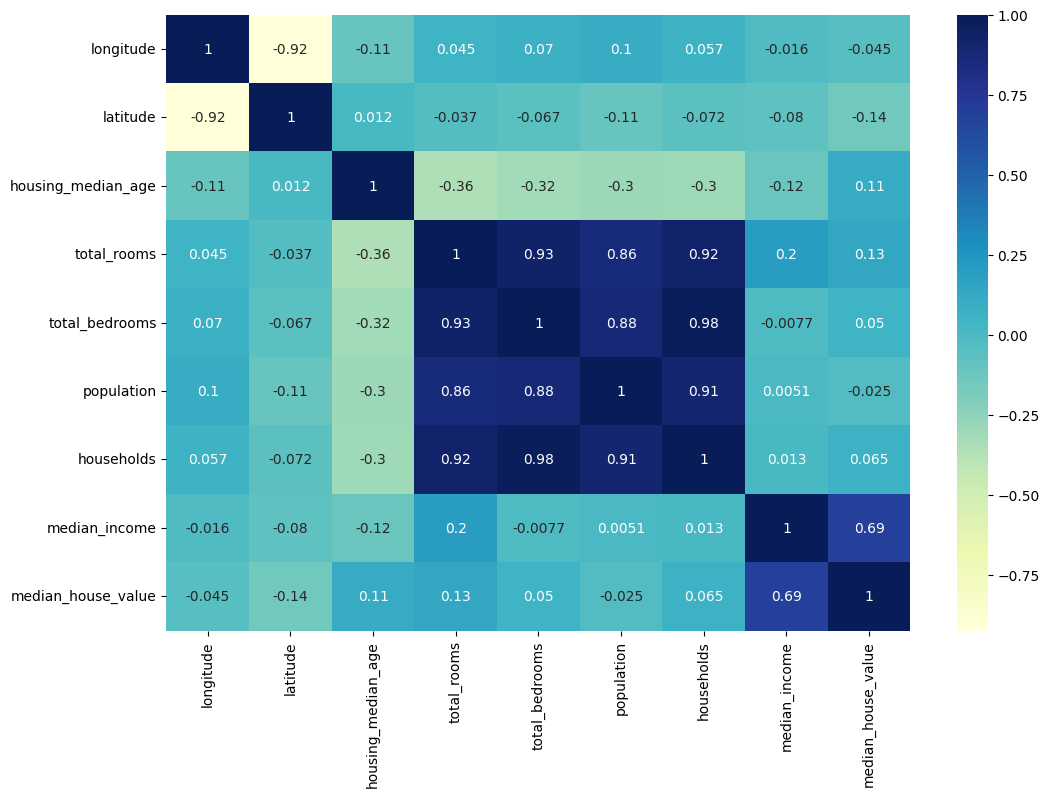

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(df.drop('ocean_proximity', axis=1).corr(),
            annot=True,
            cmap='YlGnBu')

- The (median_income) feature is highly correlates with the (median_house_value), which is our target value.
- The (total_rooms) and (housing_median_age) features are positively correlated with the target a little bit.
- The (latitude) feature is negatively correlated with the target a little bit.

## Preprocessing

### Checking the distribution 

[]

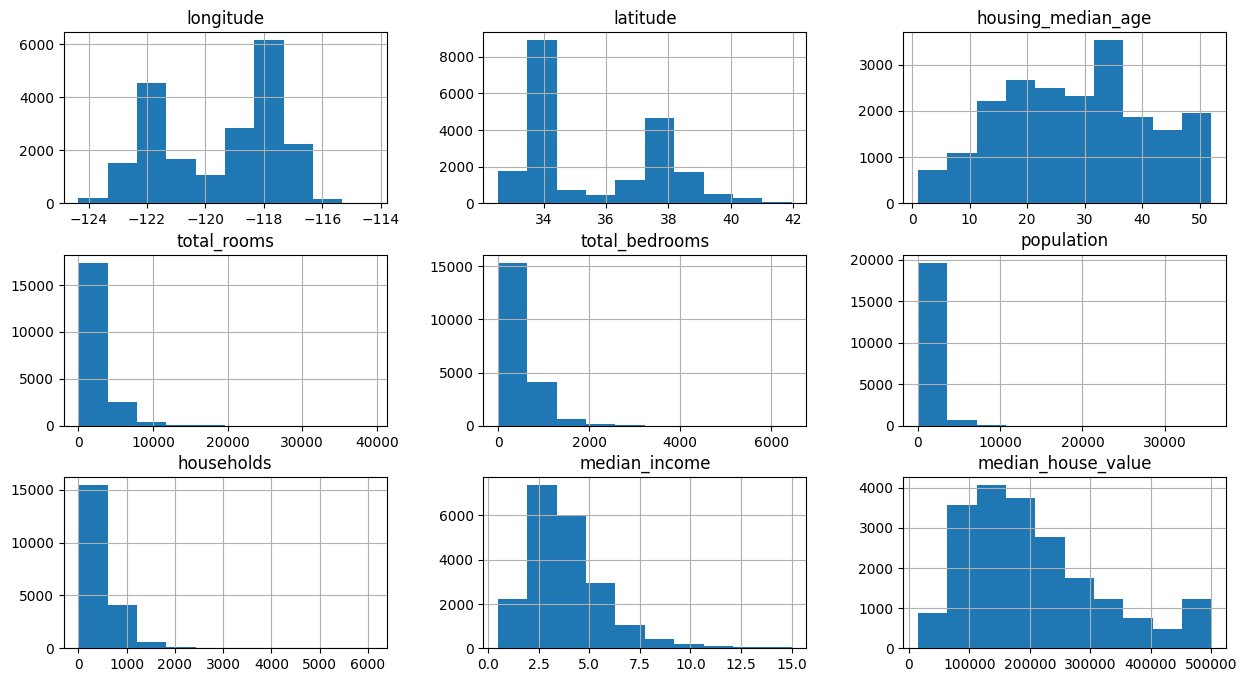

In [7]:
df.hist(figsize=(15,8))
plt.plot()

- This plot shows us that we have many right skewed features: 
    - total_rooms
    - total_bedrooms
    - population
    - households
    
So, we will take the logarithm for these features.

In [8]:
df['total_rooms'] = np.log(df['total_rooms']) + 1
df['total_bedrooms'] = np.log(df['total_bedrooms']) + 1
df['population'] = np.log(df['population']) + 1
df['households'] = np.log(df['households']) + 1

[]

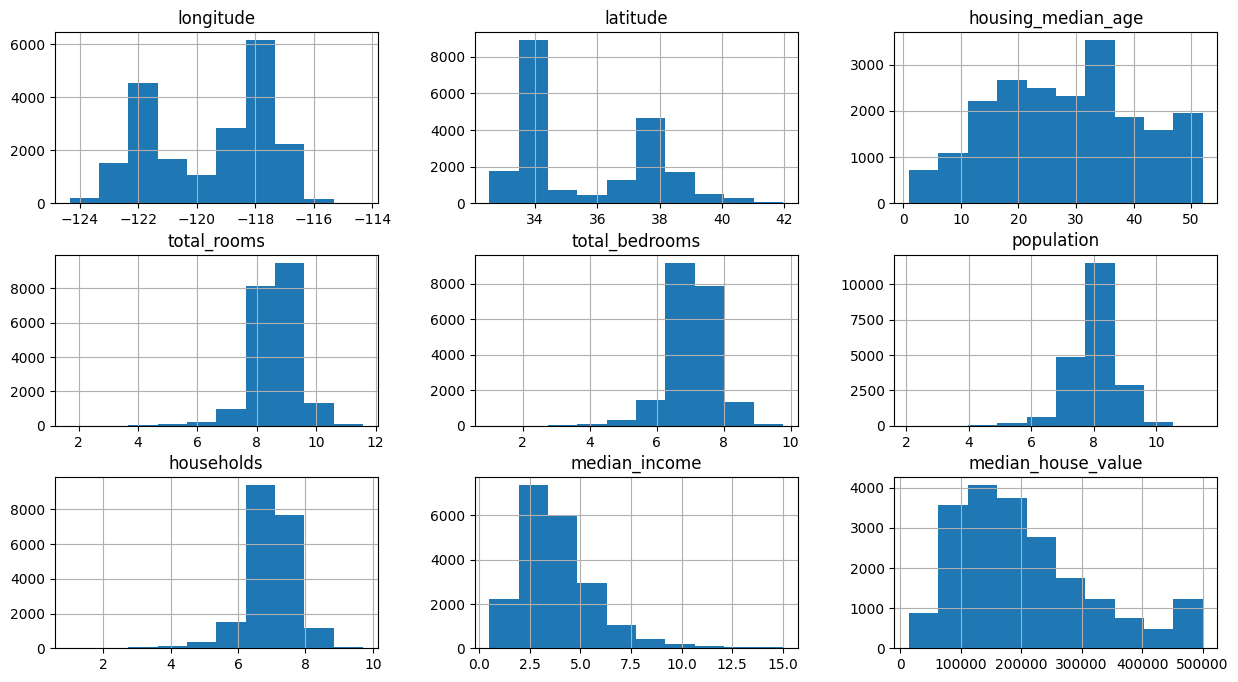

In [9]:
df.hist(figsize=(15,8))
plt.plot()

As we see, after taking the log of the skewed features, they are now normally distributed 

### Encoding

In [10]:
df['ocean_proximity'].value_counts() # this feature will be one hot encoded

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

In [11]:
df = df.join( pd.get_dummies(df['ocean_proximity'], dtype='int')).drop('ocean_proximity', axis=1)

<Axes: >

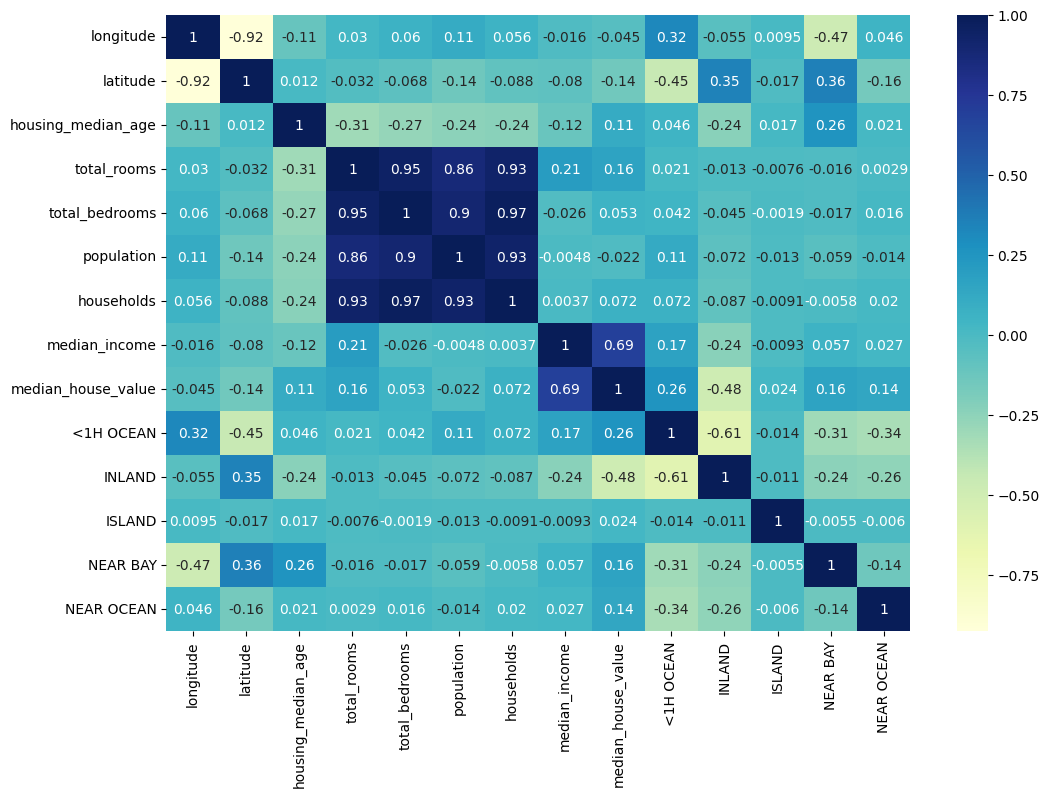

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),
            annot=True,
            cmap='YlGnBu')

After one hot encoding the feature (ocean_proximity), and taking a look on the correlation heatmap again, we see that the price of the house increases when it is near to the ocean

## Visualizing the map 

As the data contains the real coordinates of the houses (longitude and latitude features), we can plot this coordinates and make a hue by the price.

[]

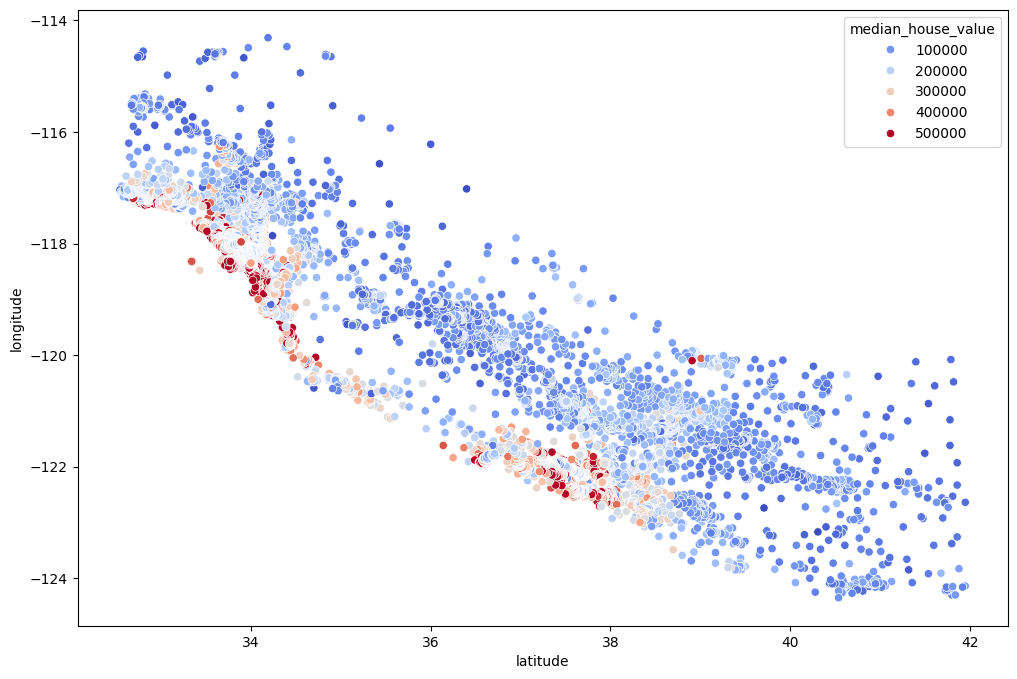

In [13]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = 'latitude', y = 'longitude', data = df, hue='median_house_value', palette='coolwarm')
plt.plot()

As we see, the red points represent houses that have high prices, and all of them are close to the ocean

## Feature Engineering

- We can create new feature that represents the ratio of bedrooms in all the rooms in the house. "bedrooms / total rooms"

- Also we need another feature that represents the rooms in a single household "total rooms / house holds"


In [14]:
df['bedroom_ratio'] = df['total_bedrooms'] / df['total_rooms']
df['household_rooms'] = df['total_rooms'] / df['households']

<Axes: >

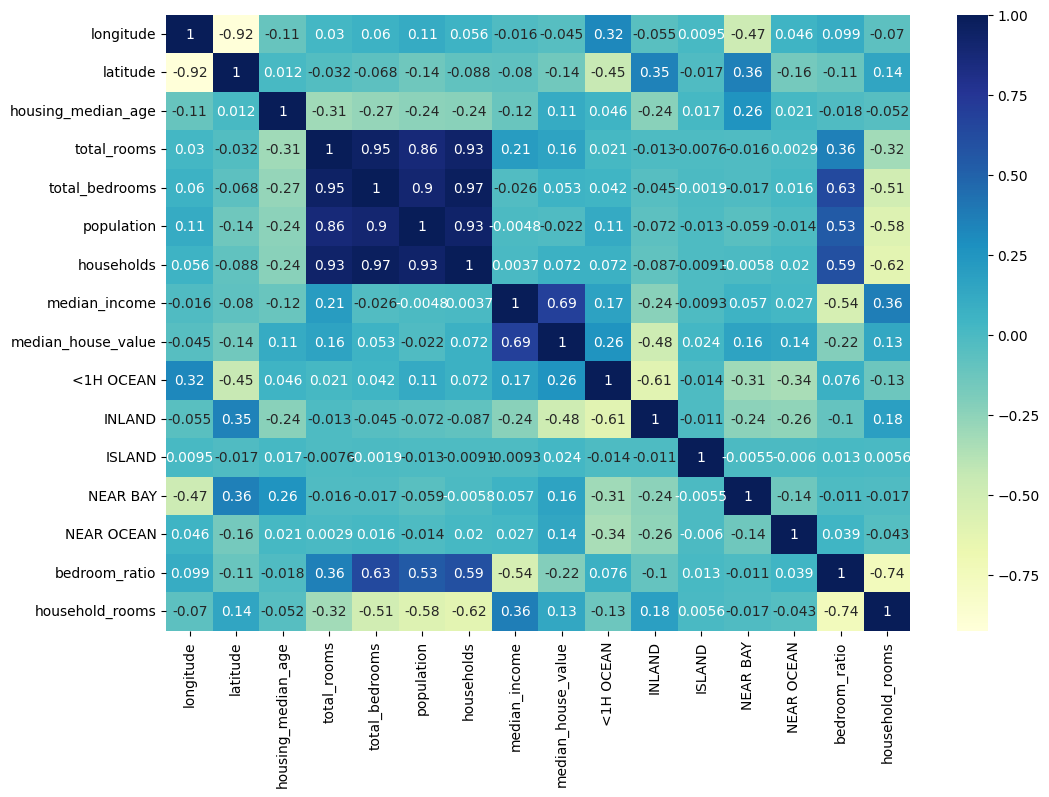

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),
            annot=True,
            cmap='YlGnBu')

As we see here, the 2 new features we created worth it.
- The 'bedroom_ratio' feature we created is correlated with the target by -0.21, which is better than the old feature 'total_bedrooms' that has correlation of 0.05
- And 'household_rooms' has correlation of 0.13, which is better than 'households' that has correlation of 0.07

## Testing models' performance


In [16]:
# changing the name to remove the "<" sign
df['hour_to_ocean'] = df['<1H OCEAN']
df.drop('<1H OCEAN', axis=1, inplace=True)

# splitting data
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Random Forest

In [17]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.8214540691474989

### XGBOOST

In [18]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_y_pred = xgb_reg.predict(X_test)
r2_score(y_test, xgb_y_pred)

0.8310496385070167

### AdaBoost

In [19]:
tree_reg = DecisionTreeRegressor()
ada_reg = AdaBoostRegressor(estimator=tree_reg)
ada_reg.fit(X_train, y_train)
ada_y_pred = ada_reg.predict(X_test)
r2_score(y_test, ada_y_pred)


0.822018794394171

As we see, the highest score is achieved by XGBOOST. So, we will try to increase its R2 score by hyper parameter tuning.

## Hyperparameter tuning for the XGBoost model

In [20]:
param_grid = {
    'n_estimators': [300,500],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.9, 1]
}

xgb_reg = XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='r2', verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END 

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.9, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 7, 9], 'n_estimators': [300, 500],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='r2', verbose=2)

### Model Evaluation

In [27]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best R2 Score:", best_score)

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}
Best R2 Score: 0.8445059969580602


In [28]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 32352.30546366528
Root Mean Squared Error: 49413.03353388964


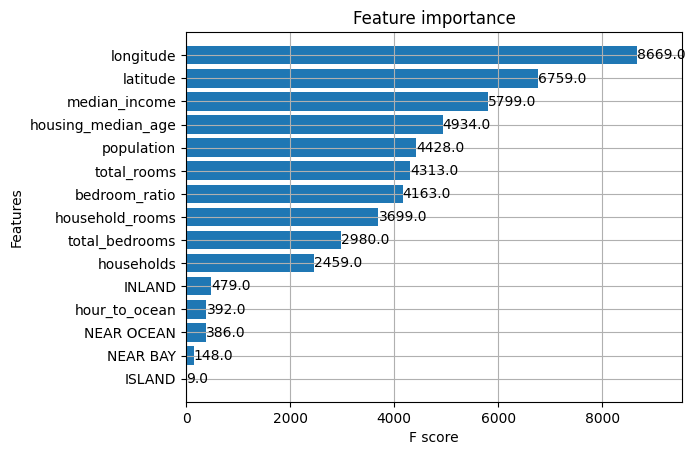

In [40]:
xgb.plot_importance(best_model, height=0.8)
plt.show()

- As we see, the model found that the most important features for this task are :
    - The location 
    - The income
    - The house Age
    - The population in this area
    - Then comes the rooms

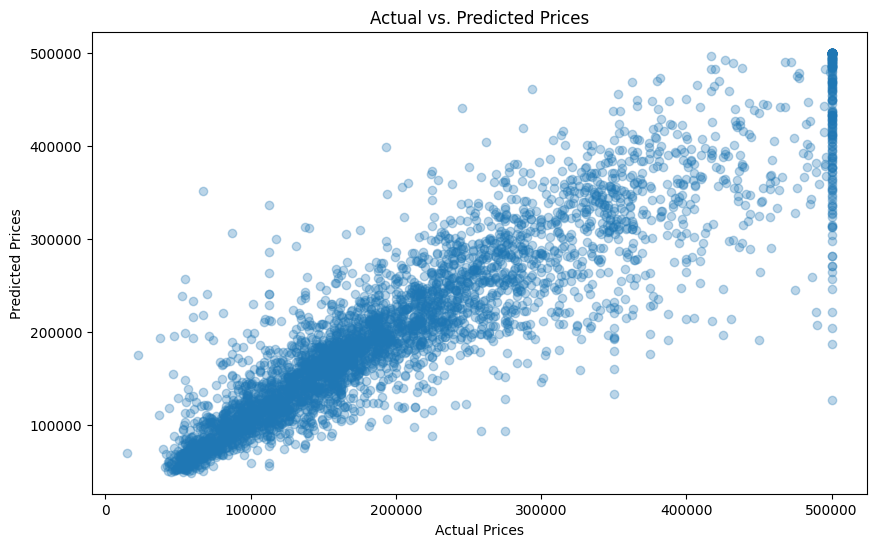

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.show()